In [1]:
# --- 1. Reikalingos bibliotekos ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import json
import pickle
from datetime import datetime, timedelta

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print(f"TensorFlow versija: {tf.__version__}")
np.random.seed(42)
tf.random.set_seed(42)

TensorFlow versija: 2.19.0


In [2]:
# --- 2. Duomenų gavimas iš Binance API (jei reikia) arba naudojami jau išsaugoti ---
cached_data_path = os.path.join('..', '..', 'data', 'btc_data_1y_15m.csv')

if os.path.exists(cached_data_path):
    print(f"Naudojami cached duomenys iš {cached_data_path}")
    df = pd.read_csv(cached_data_path)
    df['time'] = pd.to_datetime(df['time'])
    print(f"Duomenų dydis: {df.shape}")
    print(df.head())
else:
    print(f"KLAIDA: Nerastas duomenų failas {cached_data_path}")
    print("Pirma paleiskite duomenų gavimo skriptą arba kitą modelio failą, pvz., lstm_model.ipynb")

Naudojami cached duomenys iš ..\..\data\btc_data_1y_15m.csv
Duomenų dydis: (35040, 12)
                 time      open      high       low     close     volume  \
0 2024-05-21 14:00:00  70595.92  70847.77  70560.00  70777.91  584.15346   
1 2024-05-21 14:15:00  70777.91  70833.80  70329.82  70419.44  705.06014   
2 2024-05-21 14:30:00  70419.44  70927.48  70417.79  70456.81  611.94862   
3 2024-05-21 14:45:00  70456.82  70507.24  70187.76  70213.20  756.49794   
4 2024-05-21 15:00:00  70213.21  70342.68  70153.69  70247.83  669.15517   

      close_time  quote_asset_volume  number_of_trades  \
0  1716300899999        4.130733e+07             23464   
1  1716301799999        4.976077e+07             26447   
2  1716302699999        4.323031e+07             28584   
3  1716303599999        5.323694e+07             50211   
4  1716304499999        4.699733e+07             34871   

   taker_buy_base_asset_volume  taker_buy_quote_asset_volume  ignore  
0                    307.29840      

In [3]:
# --- 3. Duomenų paruošimas ir normalizavimas ---
df = df.sort_values('time')
columns_to_normalize = ['open', 'high', 'low', 'close', 'volume']
scaler = MinMaxScaler()
df_original = df.copy()
df_normalized = df.copy()
df_normalized[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

# Patikriname normalizuotus duomenis
print("Normalizuotų duomenų statistika:")
print(df_normalized[columns_to_normalize].describe())

# Išsaugome scaler'į vėlesniam naudojimui
import pickle
os.makedirs('../../models', exist_ok=True)
with open('../../models/cnn_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

Normalizuotų duomenų statistika:
               open          high           low         close        volume
count  35040.000000  35040.000000  35040.000000  35040.000000  35040.000000
mean       0.504274      0.496868      0.514773      0.504292      0.031584
std        0.274743      0.274887      0.274528      0.274753      0.040543
min        0.000000      0.000000      0.000000      0.000000      0.000000
25%        0.242512      0.234315      0.253421      0.242504      0.010924
50%        0.547065      0.540466      0.556620      0.547083      0.019525
75%        0.777161      0.769569      0.787709      0.777164      0.036745
max        1.000000      1.000000      1.000000      1.000000      1.000000


In [4]:
# --- 4. Sliding window sekų kūrimas ---
def create_sequences(data, target_column, sequence_length):
    X, y = [], []
    feature_columns = ['open', 'high', 'low', 'close', 'volume']
    data_array = data[feature_columns].values
    target_idx = feature_columns.index(target_column)
    for i in range(len(data) - sequence_length):
        X.append(data_array[i:i + sequence_length])
        y.append(data_array[i + sequence_length, target_idx])
    return np.array(X), np.array(y)

sequence_length = 60  # CNN gali efektyviai dirbti su ilgesnėmis sekomis
target_column = 'close'
feature_columns = ['open', 'high', 'low', 'close', 'volume']
X, y = create_sequences(df_normalized, target_column, sequence_length)
print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (34980, 60, 5), y shape: (34980,)


In [5]:
# --- 5. Duomenų padalijimas į mokymo ir testavimo rinkinius ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

X_train shape: (27984, 60, 5), X_test shape: (6996, 60, 5)
y_train shape: (27984,), y_test shape: (6996,)


In [6]:
# --- 6. CNN modelio sukūrimas ---
def create_cnn_model(input_shape):
    model = models.Sequential([
        # 1D konvoliucijos sluoksniai
        layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
        layers.MaxPooling1D(pool_size=2),
        layers.BatchNormalization(),
        
        layers.Conv1D(filters=128, kernel_size=3, activation='relu'),
        layers.MaxPooling1D(pool_size=2),
        layers.BatchNormalization(),
        
        layers.Conv1D(filters=128, kernel_size=3, activation='relu'),
        layers.BatchNormalization(),
        
        # Tankinimo sluoksniai
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)  # Išvesties sluoksnis (kainų prognozė)
    ])
    return model

# Sukuriame modelį
input_shape = (X_train.shape[1], X_train.shape[2])  # (sequence_length, features)
cnn_model = create_cnn_model(input_shape)

# Sukompiliuojame modelį
cnn_model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

cnn_model.summary()

d:\CA_BTC\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 58, 64)         │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 29, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 29, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 27, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 13, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 13, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 11, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 11, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       180,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 264,961 (1.01 MB)

 Trainable params: 264,321 (1.01 MB)

 Non-trainable params: 640 (2.50 KB)

In [7]:
# --- 7. Modelio apmokymas ---
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)
checkpoint = callbacks.ModelCheckpoint(
    filepath='../../models/cnn_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.0001,
    verbose=1
)

# Apmokymo paleidimas
print("Pradedamas modelio apmokymas...")
history = cnn_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, checkpoint, reduce_lr],
    verbose=1
)

print("Modelio apmokymas baigtas.")

# Išsaugome modelį
cnn_model.save('../../models/cnn_model.h5')
print("Modelis išsaugotas į: ../../models/cnn_model.h5")

Pradedamas modelio apmokymas...
Epoch 1/100
871/875 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1794 - mae: 0.2462
Epoch 1: val_loss improved from inf to 0.00451, saving model to ../../models/cnn_model.h5


875/875 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - loss: 0.1787 - mae: 0.2456 - val_loss: 0.0045 - val_mae: 0.0592 - learning_rate: 0.0010
Epoch 2/100
870/875 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0061 - mae: 0.0586
Epoch 2: val_loss improved from 0.00451 to 0.00221, saving model to ../../models/cnn_model.h5


875/875 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0061 - mae: 0.0586 - val_loss: 0.0022 - val_mae: 0.0370 - learning_rate: 0.0010
Epoch 3/100
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0040 - mae: 0.0467
Epoch 3: val_loss did not improve from 0.00221
875/875 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.0040 - mae: 0.0467 - val_loss: 0.0032 - val_mae: 0.0412 - learning_rate: 0.0010
Epoch 4/100
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - mae: 0.0406
Epoch 4: val_loss did not improve from 0.00221
875/875 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0030 - mae: 0.0406 - val_loss: 0.0023 - val_mae: 0.0404 - learning_rate: 0.0010
Epoch 5/100
873/875 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0025 - mae: 0.0370
Epoch 5: val_loss improved from 0.00221 to 0.00152, saving model to ../../models/cnn_model.h5


875/875 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.0025 - mae: 0.0370 - val_loss: 0.0015 - val_mae: 0.0299 - learning_rate: 0.0010
Epoch 6/100
873/875 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0023 - mae: 0.0356
Epoch 6: val_loss did not improve from 0.00152
875/875 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.0023 - mae: 0.0356 - val_loss: 0.0045 - val_mae: 0.0586 - learning_rate: 0.0010
Epoch 7/100
873/875 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0019 - mae: 0.0321
Epoch 7: val_loss did not improve from 0.00152
875/875 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.0019 - mae: 0.0321 - val_loss: 0.0058 - val_mae: 0.0595 - learning_rate: 0.0010
Epoch 8/100
873/875 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0018 - mae: 0.0307
Epoch 8: val_loss did not improve from 0.00152
875/875 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.0018 - mae: 0.0307 - val_loss: 0.0041 - val_mae: 0.0556 - learning_rate: 0.0010
Epoch 9/100
870/875 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0016 - mae: 0.

875/875 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.0011 - mae: 0.0243 - val_loss: 0.0014 - val_mae: 0.0279 - learning_rate: 5.0000e-04
Epoch 12/100
873/875 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.5717e-04 - mae: 0.0216
Epoch 12: val_loss improved from 0.00141 to 0.00102, saving model to ../../models/cnn_model.h5


875/875 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 8.5721e-04 - mae: 0.0216 - val_loss: 0.0010 - val_mae: 0.0259 - learning_rate: 5.0000e-04
Epoch 13/100
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.5078e-04 - mae: 0.0212
Epoch 13: val_loss did not improve from 0.00102
875/875 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 8.5075e-04 - mae: 0.0212 - val_loss: 0.0069 - val_mae: 0.0735 - learning_rate: 5.0000e-04
Epoch 14/100
873/875 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9.0619e-04 - mae: 0.0217
Epoch 14: val_loss did not improve from 0.00102
875/875 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 9.0597e-04 - mae: 0.0217 - val_loss: 0.0078 - val_mae: 0.0743 - learning_rate: 5.0000e-04
Epoch 15/100
874/875 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.0867e-04 - mae: 0.0203
Epoch 15: val_loss did not improve from 0.00102
875/875 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 8.0870e-04 - mae: 0.0203 - val_loss: 0.0020 - val_mae: 0.0356 - learning_rate: 5.0000e-04
Epoch 16/100
874/875 ━━━━━━━━━━━━━

Modelio apmokymas baigtas.
Modelis išsaugotas į: ../../models/cnn_model.h5


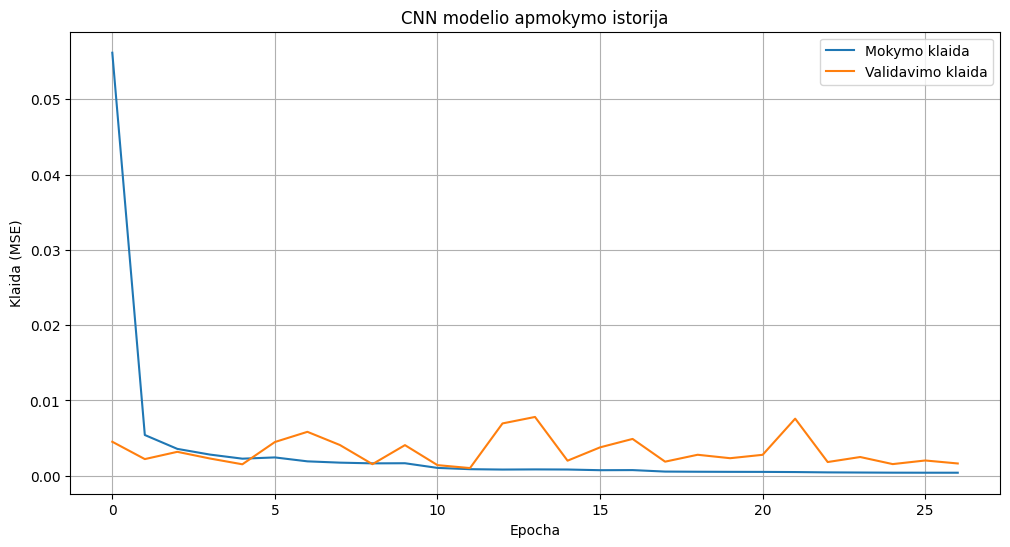

In [8]:
# --- 8. Apmokymo istorijos vizualizacija ---
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Mokymo klaida')
plt.plot(history.history['val_loss'], label='Validavimo klaida')
plt.title('CNN modelio apmokymo istorija')
plt.xlabel('Epocha')
plt.ylabel('Klaida (MSE)')
plt.legend()
plt.grid(True)
plt.show()

if 'lr' in history.history:
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['lr'])
    plt.title('Learning Rate Kitimas')
    plt.xlabel('Epocha')
    plt.ylabel('Learning Rate')
    plt.grid(True)
    plt.show()

In [9]:
# --- 9. Modelio testavimas ---
y_pred = cnn_model.predict(X_test)

def inverse_transform_predictions(predictions, scaler, target_idx=3, feature_names=None):
    dummy = np.zeros((len(predictions), len(feature_names) if feature_names else 5))
    dummy[:, target_idx] = predictions.flatten()
    inverse_predicted = scaler.inverse_transform(dummy)
    return inverse_predicted[:, target_idx]

target_idx = feature_columns.index(target_column)
y_pred_original = inverse_transform_predictions(y_pred, scaler, target_idx, feature_columns)
y_test_original = inverse_transform_predictions(y_test.reshape(-1, 1), scaler, target_idx, feature_columns)

219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [10]:
# --- 10. Modelio įvertinimas ---
mse = mean_squared_error(y_test_original, y_pred_original)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_original, y_pred_original)
r2 = r2_score(y_test_original, y_pred_original)
mape = np.mean(np.abs((y_test_original - y_pred_original) / y_test_original)) * 100

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Sukuriame DataFrame geresniam pavaizavimui
metrics_df = pd.DataFrame({
    'Metrika': ['MSE', 'RMSE', 'MAE', 'R²', 'MAPE (%)'],
    'Reikšmė': [mse, rmse, mae, r2, mape]
})
display(metrics_df)

Mean Squared Error (MSE): 3572114.43
Root Mean Squared Error (RMSE): 1890.00
Mean Absolute Error (MAE): 1534.32
R² Score: 0.9472
Mean Absolute Percentage Error (MAPE): 1.68%


,Metrika,Reikšmė
0,MSE,3.572114e+06
1,RMSE,1.890004e+03
2,MAE,1.534315e+03
3,R²,9.471958e-01
4,MAPE (%),1.684834e+00


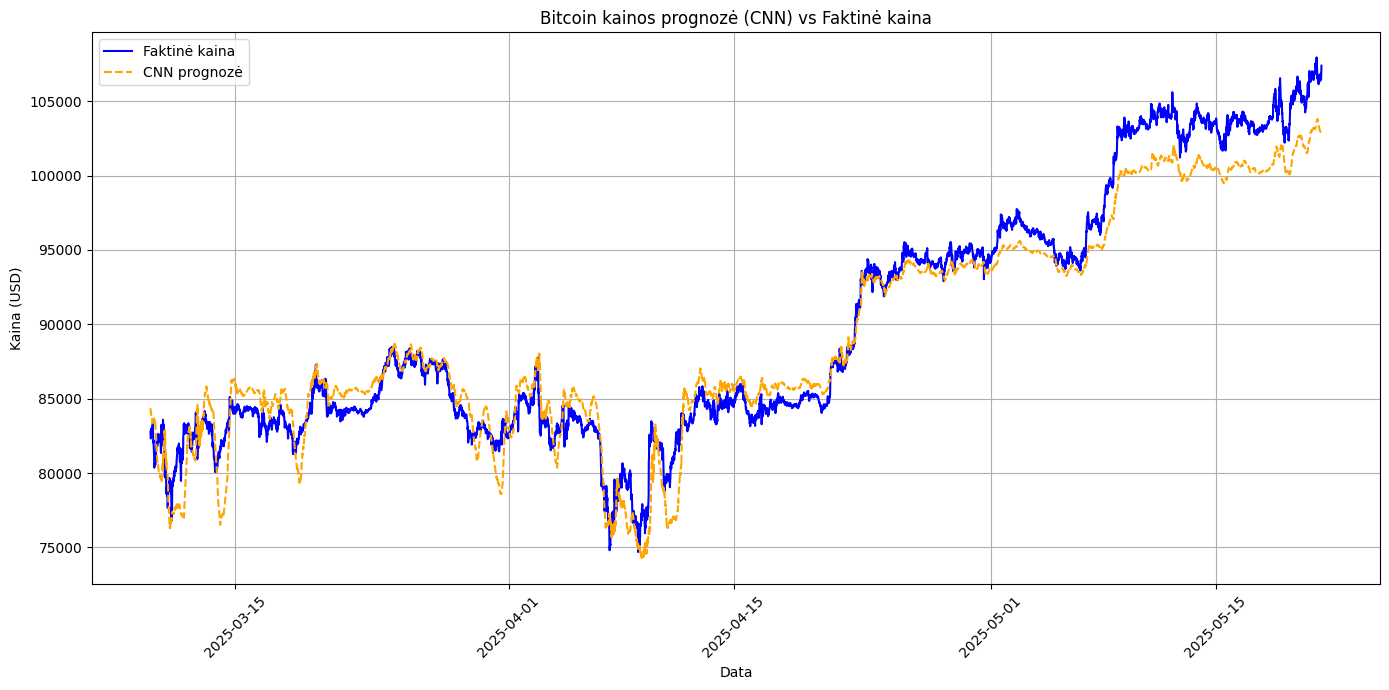

In [11]:
# --- 11. Prognozių vizualizacija ---
# Pasiimame testavimo rinkinių datas
test_dates = df_original['time'].iloc[-len(y_test):].reset_index(drop=True)

plt.figure(figsize=(14, 7))
plt.plot(test_dates, y_test_original, label='Faktinė kaina', color='blue')
plt.plot(test_dates, y_pred_original, label='CNN prognozė', color='orange', linestyle='--')
plt.title('Bitcoin kainos prognozė (CNN) vs Faktinė kaina')
plt.xlabel('Data')
plt.ylabel('Kaina (USD)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [12]:
# --- 12. Modelio informacijos išsaugojimas ---
model_info = {
    'model_type': 'CNN',
    'input_shape': [sequence_length, len(feature_columns)],
    'sequence_length': sequence_length,
    'target_column': target_column,
    'metrics': {
        'mse': float(mse),
        'rmse': float(rmse),
        'mae': float(mae),
        'r2': float(r2),
        'mape': float(mape)
    }
}

model_info_path = '../../models/cnn_model_info.json'
with open(model_info_path, 'w') as f:
    json.dump(model_info, f, indent=4)

print(f"Modelio informacija išsaugota: {model_info_path}")

Modelio informacija išsaugota: ../../models/cnn_model_info.json
